# Chapter 7
## Ensemble Learning and Random Forests

By aggregating the responses of a group of predictors, we can generally get better predictions than if we were using a single predictor.
Such a group of predictors is called an *ensemble*; thus this technique is called **Ensemble Learning**

In the last exercise of chapter 6, we created an ensemble of Decision Trees, which formed a *Random Forest*.

Ensemble methods are typically used near the end of a project once you already have built a few good predictors, to combine them into an even better predictor.

In this chapter we will discuss the most popular Ensemble methods, including *bagging*, *boosting* and *stacking*. We will also explore Random Forests.

## Voting Classifiers

Suppose we have trained a Logistic Regression classifier, a SVM classifier and a Random Forest classifier, each achieving about 80% accuracy.

A very simple way of creating a better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a *hard voting classifier*. This type of voting classifier often achieves higher accuracy than the best classifier in the ensemble.

In fact if even if a classifier is a *weak learner* (i.e. only slightly better than random guessing), the ensemble can still be a *strong learner* provided there are a sufficient number of weak learners and they are sufficiently diverse.

This happens due to the law of large numbers (see coin tossing explanation pg 191). 

Thus suppose we build an ensemble containing 1,000 classifiers that are individually correct 51% of the time. By using majority voting, we can hope for up to 75% accuracy.

However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble's accuracy.

**Note:** Ensemble methods work best when predictors are as independent from one another as possible. A good way to achieve this is to train them using very different algorithms, increasing the chance they will make very different types of errors, thus improving the ensemble's accuracy.

Example of a hard voting classifier

In [1]:
# Generate data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


If the classifiers can estimate class probabilities(i.e. the have the predict_proba method), we can set skelearn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft-voting*. (set voting=soft)

It often achieves higher performance than hard voting because it gives more weight to highly confident votes. 

For the above, we SVC does not output class probabilities by defaultm but we can set its **probability** hyperparameter to True to output probabilities and use soft voting.

## Bagging and Pasting

Another way to get a diverse set of classifiers is to train the same algorithm using different subsets of the training set. When sampling is performing with replacement, this is called *bagging*, and when it is performed without replacement, it is called *pasting*.

Once all predictors are trained, the ensemble can make a prediction based on the type of problem. For classifiers it uses the statistical *mode* (similar to a hard voting classifier) and for regressors it uses the *mean*.

Each individual classifier will have higher bias than if it were trained on the full training set, but aggregation reduces bias and variance. Generally the ensemble has similar bias but lower variance than a single predictor trained on the full training set.

Another advantage of baggind and pasting is that predictors can be trained in different CPU cores and evenr across different servers. Predictions can also be made in parallel.

This means they are very scalable methods

In [4]:
# Sklearn example
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, # Train 500 classifiers
    max_samples=100,  # On subsets of size 100
    bootstrap=True,    # Sampling data with replacement (set=False for pasting)
    n_jobs=-1         # Use all cores available
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
accuracy_score(y_test, y_pred)

0.904

*Note:* The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e. has a predict_proba method)

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

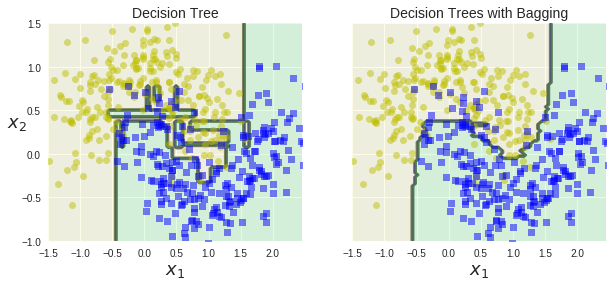

In [7]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

The figure above compares a DecisionTree with a bagging classifier. The models have similar bias (i.e. make the roughly the same number of errors) but the bagging classifier has lesser variance, it's decision boundary is much less irregular.

Generally boostrapping adds a bit more diversity to the subsets each predictor uses, thus bagging usually ends up with a slighly higher bias than pasting. But the extra diversity means the predictors ends up being less correlated so the ensemble's variance is reduced. 

### Out-of-Bag evaluation

When using bagging, some training instances might be sampled multiple times, while others might not be sampled at all. By default, a BaggingClassifier samples *m* training instances with replacement where *m* is the size of the training set. 

This means only 63% of the training instances are sampled on average for each predictor, with the remaining 37% being called *out-of-bag (oob)* instances. (They are not the same 37% for all predictors) 

We can use these oob sample to evaluate predictors without a need for a testing set. We can set oob_score=True to request automatic oob evaluation after training.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100,  bootstrap=True, oob_score=True,
    n_jobs=-1
)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9253333333333333

In [10]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We can also access the decision function for the oob samples

In [11]:
bag_clf.oob_decision_function_[:10]

array([[0.33070866, 0.66929134],
       [0.38242894, 0.61757106],
       [1.        , 0.        ],
       [0.01923077, 0.98076923],
       [0.03157895, 0.96842105],
       [0.09585492, 0.90414508],
       [0.37837838, 0.62162162],
       [0.08311688, 0.91688312],
       [0.93931398, 0.06068602],
       [0.86445013, 0.13554987]])

### Random Patches and Random Subspaces

The BaggingClassifier also supports sampling of *features* by using max_features and bootstrap_features. They work similarly to the max_samples and bootstrap parameters but sample input features instead of training data. Thus each predictor will be trained on a random subset of the input features.

This can be useful when dealing with high-dimensional data (such as images).

Sampling both training instances and features is called the *Random Patches* method.

Keeping all training instances but sampling features is called the *Random Subspace* method

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance

## Random Forests

RandomForests are ensembles of Decision Trees, usually trained via bagging method. Instead of building a BaggingClassifier and passing it Decision Trees, we can simply use the RandomForest class.

The bagging classifier is still useful if we want to bag something other than decision trees.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred_rf)

0.92

With a few excetptions, the RandomForestClassifier has all the hyperparameters of DecisionTrees plus all of those of the BaggingClassifier. 

Exceptions are: splitter (set to random), presort (set to false), max_samples (set to 1.0) and base_estimator is forced to DecisionTreeClassifier.

RandomForests introduce extra randomness when growing trees: instead of searching for the best feature when splitting a node, it searches for the best feature among a random *subset* of features. This results in greater tree diversity, which trades a higher bias fro a lower variance, yielding an overall better model

### Extra-Trees

We can introduce extra randomness when growing a forest by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

These forests are known as *Extremely Randomized Trees* (Extra Trees for short). Again, this trades higher bias for lower variance. Extra Trees are also faster to train than Random Forests because finding the best possible threshold is one of the more time-consuming tasks of growing a tree.

ScikitLean has the ExtraTreesClassifier class and its API is identical to the RandomForestClassifier. (same for regressor)

### Feature Importance

We can measure the importance of each feature in a Random Forest, which in turn can help us to identify useful features. ScikitLearn  measures importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it.

This score is computed automatically after training and results are then scaled so that the sum of all importances is 1. We can access these with the feature_importances_ variable.
The following code grows a random forest on the iris dataset prints features importances.

In [15]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09374894940904009
sepal width (cm) 0.02360405876023157
petal length (cm) 0.43936811785531293
petal width (cm) 0.44327887397541543


See book for plot of feature importances for MNIST.

## Boosting

*Boosting* refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

### AdaBoost

One way to correct a predecessor instance, is for the model to pay more attention to the misclassified training instances. This results in predictions focused more and more on the hard cases. This is the technique used by AdaBoost.

For example, AdaBoost starts by training a base classifier (e.g. DecisionTree) and uses that to make predictions on the training set.

The algorithm then increases the relative weight of misclassified training instances.

Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on...

The plot below shows the decision boundaries of five consecutive predictors on the moons dataset.

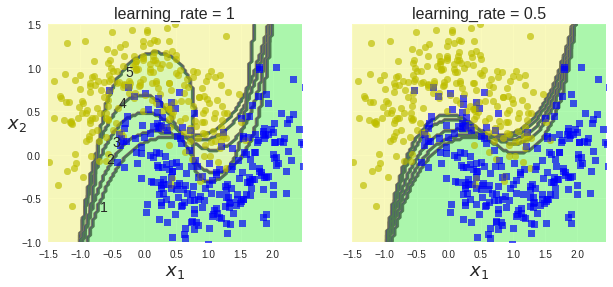

In [19]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

Each predictor is a highly regularized SVM. With each iteration the weights are updated and it's predictions get better. This has some similarities to Gradient Descent, except that instead of tweaking a single predictor's parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Let's have a look at the inner workings of AdaBoost!

Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. The first predictor is trained and its weighted error rate $r_1$ is computed on the training set. $r_j$ is defined as:

$$ r_j = \frac{\sum_{\substack{i=1 \\ \hat{y}_{j}^{(i)} \neq y^{(i)}}}^{m}{w^{(i)}}} {\sum_{i=1}^{m}w^{(i)}}$$

Where $\hat{y}_{j}^{(i)}$ is the j-th predictor's prediction for the i-th instance.

The predictor's weight $\alpha_j$ is then computed using the following equation:

$$ \alpha_j = \eta \log\frac{1-r_j}{r_j} $$

The more accurate the predictor is, the higher the weight; if it is just guessing randomly its weight will be close to zero and if it is mostly wrong, its weight will be negative

Next, AdaBoost updates the instances weights with the following rule for $i=1,...,m$

$$ w^{(i)} \leftarrow \begin{cases} w^{(i)} & \hat{y_j}^{(i)} = y^{(i)} \\
                                    w^{(i)}\exp(\alpha_j) & \hat{y_j}^{(i)} \neq y^{(i)}
                      \end{cases}$$
                      
Then all instance weights are normalized (i.e. divided by $\sum_{i=1}^{m}w^{(i)}$)

Finally a new predictor is trained using the updated weights and the whole process i repeated (the new predictor's weight is computed, the instance weights are upated, anothe predictor trained and so on...)

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

$$ \hat{y}(\textbf{x}) = \underset{k}{\mathrm{argmax}} \sum_{\substack{j=1 \\ \hat{y_j}^{(i)}(\textbf{x})=k}}^{N}\alpha_j $$

Where N is the number of predictors

Sklearn uses a multiclass version of AdaBoost called SAMME (*Stagewise Additive Modeling using a Multiclass Exponential loss function*). With two classes SAMME is equivalent to AdaBoost. If predictors can estimate class probabilities, it uses SAMME.R (R for real), which uses class probabilities and in general performs better.

The code below trains an AdaBoost classifier on 200 *Decision Stumps* (decition tree with max_depth=1). This is the default base estimator for the AdaBoostClassifier

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=20, 
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)

accuracy_score(y_test, y_pred_ada)

0.896